# Art Price Prediction Using Transfer Learning

## Notebook Overview

In this notebook, we aim to build a deep learning regression model capable of predicting artwork prices based solely on their images.
We will go through the following main steps:

* **Data Loading and Preparation**  

* **Image Preprocessing**  

* **Model Definition (Transfer Learning)**  

* **Model Training**  

* **Evaluation and Visualization**  

* **Model Saving**  

# Imports


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib

import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import (Dense, Dropout, Activation, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Dataset

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the csv
url='/content/drive/MyDrive/Colab Notebooks/the value of art/The Value of Art_scraping/saatchi_art_data_clean1.csv'

df = pd.read_csv(url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(20)

,Unnamed: 0,title,artist,price,size,painting type,url,path,material,style,area,original
0,0,"Flowers, Paintings",Elena Hromova,2530,39.4 x 39.4 in,Print of Art Deco Botanic Paintings,https://www.saatchiart.com/saatchi-images/saat...,saatchi_art_images/1.jpg.jpg,Acrylic on Canvas,Art Deco Botanic,1552.36,0
1,1,"Tranquil Sanctuary Ii, Paintings",Alissa Kim Tjen,1455,36 x 24 in,Print of Abstract Landscape Paintings,https://www.saatchiart.com/saatchi-images/saat...,saatchi_art_images/2.jpg.jpg,Acrylic on Canvas,Abstract Landscape,864.00,0
2,2,"Highest Good, Paintings",Adam Collier Noel,5550,36 x 48 in,Original Abstract Typography Paintings,https://www.saatchiart.com/saatchi-images/saat...,saatchi_art_images/3.jpg.jpg,Acrylic on Canvas,Abstract Typography,1728.00,1
3,3,"Mirror Series Untitled Portrait, Paintings",Tomoya Nakano,3287,21.2 x 29.5 in,Original Abstract Women Paintings,https://www.saatchiart.com/saatchi-images/saat...,saatchi_art_images/4.jpg.jpg,Oil on Paper,Abstract Women,625.40,1
4,4,"Barcelona 2022, Paintings",David Farrés Calvo,1315,36.2 x 23.6 in,Original Fine Art Cities Paintings,https://www.saatchiart.com/saatchi-images/saat...,saatchi_art_images/5.jpg.jpg,Oil on Canvas,Fine Art Cities,854.32,1
5,5,"The Cheeseburger Deluxe, Paintings",Matthew Haghighi,3735,24 x 36 in,Original Realism Food Paintings,https://www.saatchiart.com/saatchi-images/saat...,saatchi_art_images/6.jpg.jpg,Acrylic on Canvas,Realism Food,864.00,1
6,6,"Thrasher Magazine - Tony Hawk Bones, Paintings",Matthew Haghighi,2685,24 x 30 in,Original Pop Art Pop Culture/Celebrity Paintings,https://images.saatchiart.com/saatchi/2380599/...,saatchi_art_images/7.jpg.jpg,Acrylic on Canvas,Pop Art Pop Culture/Celebrity,720.00,1
7,7,"Mad Girl'S Love Song, Paintings",Amber Penney,1950,24 x 24 in,Original Abstract Expressionism Language Paint...,https://images.saatchiart.com/saatchi/1081013/...,saatchi_art_images/8.jpg.jpg,Acrylic on Canvas,Abstract Expressionism Language,576.00,1
8,8,"Symphony Of Dreams, Paintings",Katarina Branisova,1518,19.7 x 27.6 in,Original Contemporary Women Paintings,https://images.saatchiart.com/saatchi/2197603/...,saatchi_art_images/9.jpg.jpg,Acrylic on Canvas,Contemporary Women,543.72,1
9,9,"Untitled 2023, Paintings",Mary Ann Wakeley,1300,19 x 24 in,Original Contemporary Abstract Paintings,https://images.saatchiart.com/saatchi/338418/a...,saatchi_art_images/10.jpg.jpg,Acrylic on Paper,Contemporary Abstract,456.00,1


## Creating price_df

In [ ]:
df['price'] = df['price'].astype(int)
df["price"].value_counts()

,count
price,
3735,20
1605,15
625,15
670,15
5902,12
...,...
5865,1
2845,1
728,1


In [ ]:
# Create price_df with file name and corresponding price
price_df = df[['price']]
price_df['file_name'] = [f"{i+1}.jpg" for i in range(len(price_df))]
price_df

/tmp/ipython-input-5-3083022803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['file_name'] = [f"{i+1}.jpg" for i in range(len(price_df))]


,price,file_name
0,2530,1.jpg
1,1455,2.jpg
2,5550,3.jpg
3,3287,4.jpg
4,1315,5.jpg
...,...,...
1995,3599,1996.jpg
1996,2963,1997.jpg
1997,3395,1998.jpg
1998,1470,1999.jpg


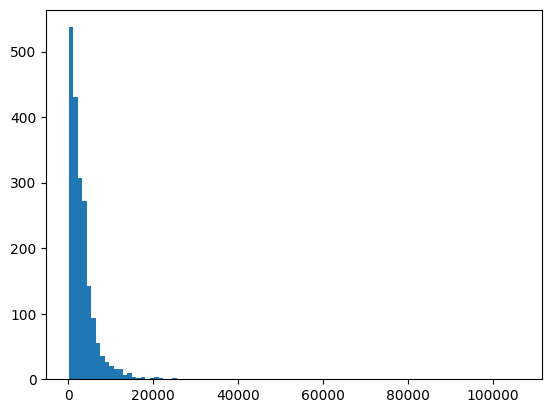

In [ ]:
plt.hist(price_df['price'], bins=100)
plt.show()

In [ ]:
# Normalize PRICES using log-scale (if skewed)
price_df['price'] = np.log(price_df['price'])

/tmp/ipython-input-7-770100398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['price'] = np.log(price_df['price'])


In [ ]:
price_df.head()

,price,file_name
0,7.835975,1.jpg
1,7.282761,2.jpg
2,8.621553,3.jpg
3,8.097731,4.jpg
4,7.181592,5.jpg


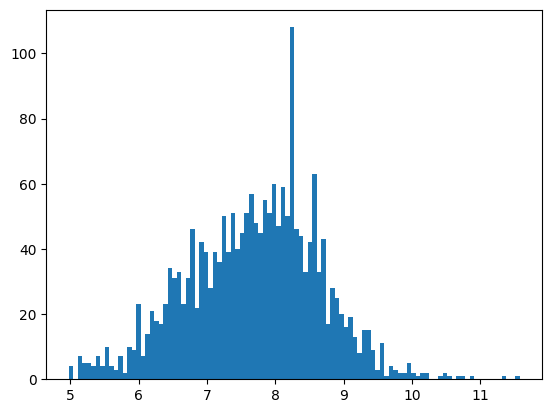

In [ ]:
plt.hist(price_df['price'], bins=100)
plt.show()

## Dataset Preparation: Loading, Processing and Shuffling Images




**Preparing tf.data Pipeline from Image Filenames and Price Labels**

Here, we'll create a `Tensorflow Datasets` object.
This will allow us to:


*   Grab images from our directory batch by batch
*   Reshape all the images to our desired input shape (224x224)



##Train, test and val_dataset tensors

In [ ]:
# Path to the image folder
image_dir = '/content/drive/MyDrive/Colab Notebooks/the value of art/The Value of Art_scraping/saatchi_art_images_final'

# Create a tf.data.Dataset from the arrays
file_names = tf.constant(price_df['file_name'].values)
prices = tf.constant(price_df['price'].values, dtype=tf.float32)

dataset = tf.data.Dataset.from_tensor_slices((file_names, prices))

# Shuffle the dataset before mapping and splitting
# Use a large buffer_size for better shuffling
buffer_size = len(price_df) # Shuffle the entire dataset
dataset = dataset.shuffle(buffer_size)

# Function to load and process a single image
def load_image(file_name, label):
    # Assuming image_dir is defined elsewhere and accessible
    img_path = tf.strings.join([image_dir, file_name], separator=os.sep)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)   # PNG, JPEG etc
    img.set_shape([None, None, 3])                                          # Ensures consistent shape after decoding
    img = tf.image.resize(img, [224, 224])                                  # Resize as needed
    label = tf.reshape(label, [1])                                          # Reshape the label to have shape (1,)
    return img, label

# Map the load_image function to load and process each imagem
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the dataset again before splitting
dataset = dataset.shuffle(buffer_size=len(price_df), seed=42)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(price_df)

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # garantir 100%

# Split datasets
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(val_size)

# Batching e prefetch
batch_size = 64

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Baseline em log





In [ ]:
# Mean and mean_absolute_erro of df['price']

from sklearn.metrics import mean_absolute_error

print("Mean of df['price']:", df['price'].mean())
print("MAE of df['price']:", mean_absolute_error(df['price'], [df['price'].mean()] * len(df['price'])))
print("MSE of df['price']:", mean_squared_error(df['price'], [df['price'].mean()] * len(df['price'])))


Mean of df['price']: 3466.646
MAE of df['price']: 2459.5964900000004
MSE of df['price']: 24023474.994684


In [ ]:
# Mean and mean_absolute_erro of price_df['price']- log!!!!

from sklearn.metrics import mean_absolute_error

print("Mean of price_df['price']:", price_df['price'].mean())
print("MAE of price_df['price']:", mean_absolute_error(price_df['price'], [price_df['price'].mean()] * len(price_df['price'])))

Mean of price_df['price']: 7.687668074273244
MAE of price_df['price']: 0.7767634423205754


# Transfer Learning - ResNet50V2

In [ ]:
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 3))

x = preprocess_input(inputs)           # preprocessing layer specifically designed for the ResNet50V2
x = base_model(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

pred = layers.Dense(1)(x)

# Keras Functional API to create our keras model

model_5 = Model(inputs=inputs , outputs=pred)

# Freeze model

base_model.trainable = False

# for layer in base_model.layers[:10]:
#     layer.trainable = False

In [ ]:
model_5.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,105,857 (91.96 MB)

 Trainable params: 541,057 (2.06 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
model_5.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

In [ ]:
MODEL = "model_5"

modelCheckpoint = callbacks.ModelCheckpoint(f"{MODEL}.keras",
                                            monitor="val_mae",
                                            verbose=0,
                                            save_best_only=True)

EarlyStopper = callbacks.EarlyStopping(monitor='val_mae',
                                       patience=20,
                                       verbose=0,
                                       restore_best_weights=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_mae",
                                        factor=0.5,
                                        patience=5,
                                        min_lr=1e-6,  # Higher minimum LR (was 0)
                                        verbose=1,
                                        cooldown=2)  # Adds 2 epochs of stability after LR change


In [ ]:
%%time
history_5 = model_5.fit(
        train_dataset,
        epochs=1000,
        validation_data=val_dataset,
        callbacks = [EarlyStopper, modelCheckpoint, LRreducer])

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - loss: 20.6476 - mae: 3.6352 - val_loss: 2.9719 - val_mae: 1.3951 - learning_rate: 0.0010
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 974ms/step - loss: 4.6722 - mae: 1.7541 - val_loss: 1.7998 - val_mae: 1.0610 - learning_rate: 0.0010
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 970ms/step - loss: 4.0801 - mae: 1.6437 - val_loss: 1.6695 - val_mae: 1.0255 - learning_rate: 0.0010
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 930ms/step - loss: 3.2374 - mae: 1.3966 - val_loss: 1.5133 - val_mae: 1.0304 - learning_rate: 0.0010
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 2.7851 - mae: 1.3377 - val_loss: 1.3689 - val_mae: 0.9495 - learning_rate: 0.0010
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 2.8803 - mae: 1.3629 - val_loss: 1.0926 - val_mae: 0.8454 - learning_rate: 0.0010
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 2.7056 - mae: 1.3170 - val_loss: 0.8048 - val_mae: 0.7124 - learning_rate: 0.

In [ ]:
loss, mae = model_5.evaluate(test_dataset)
rmse = loss ** 0.5

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - loss: 0.0762 - mae: 0.2201
RMSE: 0.27358639614084534
MAE: 0.21414881944656372


In [ ]:
# Para fazer previsões no test_dataset (que já está pré-processado e em batches):
print("\nFazendo predições no conjunto de teste (test_dataset):")
test_predictions_log = model_5.predict(test_dataset)

# Converter as predições de volta para a escala original (preço em dólares)
# y_pred
test_predictions_actual = np.exp(test_predictions_log)
# y_test
test_labels_log = np.concatenate([y for x, y in test_dataset], axis=0)
test_labels_actual = np.exp(test_labels_log)

# Verifique as dimensões para garantir que são compatíveis para o cálculo do MAE
print(f"Dimensões das Predições Reais: {test_predictions_actual.shape}")
print(f"Dimensões dos Rótulos Reais: {test_labels_actual.shape}")

# Certifique-se de que ambos os arrays tenham a mesma forma (achate-os se necessário)
test_predictions_actual_flat = test_predictions_actual.flatten()
test_labels_actual_flat = test_labels_actual.flatten()

print(f"Dimensões achatadas das Predições Reais: {test_predictions_actual_flat.shape}")
print(f"Dimensões achatadas dos Rótulos Reais: {test_labels_actual_flat.shape}")

# Calcular o Mean Absolute Error (MAE) usando os valores reais
mae_actual_scale = mean_absolute_error(test_labels_actual_flat, test_predictions_actual_flat)

print(f"\nMean Absolute Error (MAE) na escala de preço real (dólares): ${mae_actual_scale:.2f}")

# Calcular o RMSE na escala real
rmse_actual_scale = np.sqrt(mean_squared_error(test_labels_actual_flat, test_predictions_actual_flat))

print(f"Root Mean Squared Error (RMSE) na escala de preço real (dólares): ${rmse_actual_scale:.2f}")


Fazendo predições no conjunto de teste (test_dataset):
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 908ms/step
Dimensões das Predições Reais: (300, 1)
Dimensões dos Rótulos Reais: (300, 1)
Dimensões achatadas das Predições Reais: (300,)
Dimensões achatadas dos Rótulos Reais: (300,)

Mean Absolute Error (MAE) na escala de preço real (dólares): $3076.19
Root Mean Squared Error (RMSE) na escala de preço real (dólares): $6537.77


In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('mae')
    ax[1].plot(history.epoch, history.history["mae"], label="Train mae")
    ax[1].plot(history.epoch, history.history["val_mae"], label="Validation mae")
    ax[0].legend()
    ax[1].legend()

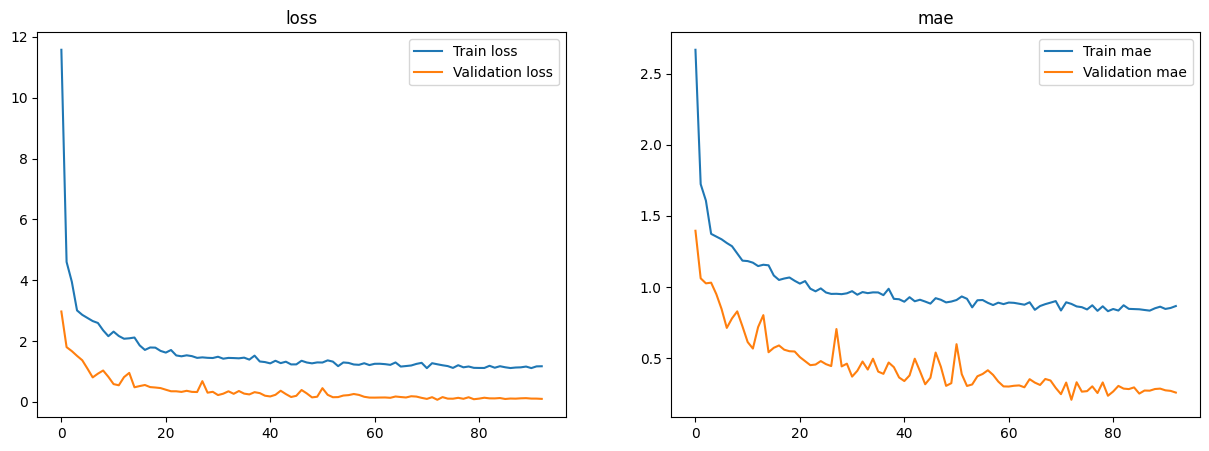

In [ ]:
plot_history(history_5)

In [ ]:
model_5.save('/content/drive/MyDrive/Modelos_salvos/final_version.keras')

In [ ]:
model_5.save('/content/drive/MyDrive/Modelos_salvos/final_version.keras')